In [49]:
import pandas as pd
from matplotlib import pyplot as plt
import glob
import matplotlib.dates as mdates
import numpy as np
from datetime import timedelta
from tqdm import tqdm
import datetime as dt
from datetime import time
import math
from datetime import datetime

Define Functions

In [50]:
def reader(path, first_var):
    '''
    Reads SEMS/DASH data, adds datetime columns

    :param path: path to data file
    :param first_var: the name of the fir column label
    :return: pandas DataFrame
    '''
    # Open the file and read the lines
    skip=1
    with open(path, "r") as file:
        # Iterate over the lines
        for line in file:
            # rip leading and trailing whitespace
            line = line.strip()
            # Check if the line contains column names
            if line.startswith(first_var):
                # Split the line by whitespace and append to the columns list
                columns = line[1:].strip().split("\t")
                break
            skip+=1
    # Read the data into a DataFrame, skipping the first 6 rows of comments
    d = pd.read_csv(path, sep='\t', skiprows=skip, names=columns, low_memory=False)
    #Check for duplicated metadata, remove metadata rows based on string "OPC SN"
    if len(d)>0:
        if isinstance(d.iloc[0,0], str):
            dup_meta = [n for n, i in enumerate(d.iloc[:,0]) if 'OPC SN' in i]
            if len(dup_meta) > 0:
                for line in dup_meta:
                    #Deletes duplicate metadata rows from dataframe
                    d.drop(np.arange(line,line+68), inplace = True)
                    # Apply the function to each column
                    d_og = d.copy()
                    for c in d.keys():
                        try:
                            d[c] = pd.to_numeric(d_og[c])
                        except:
                            d[c] = d_og[c]
                    #d = d.apply(pd.to_numeric, ‘raise’,)
                    
    # Creates datetime columns
    if 'DOY.Frac' in d.keys():
        d['dt'] = pd.to_datetime('2024-1-1') + pd.to_timedelta(d['DOY.Frac'], unit='D') - pd.Timedelta(days=1)
    if 'StartTimeSt' in d.keys():
        d['st_dt'] = pd.to_datetime('2024-1-1') + pd.to_timedelta(d['StartTimeSt'], unit='D') - pd.Timedelta(days=1)
    if 'EndTimeSt' in d.keys():
        d['end_dt'] = pd.to_datetime('2024-1-1') + pd.to_timedelta(d['EndTimeSt'], unit='D') - pd.Timedelta(days=1)
    if 'YY/MM/DD' and 'HR:MN:SC' in d.keys():
        d['dt'] = pd.to_datetime(str(20) + d['YY/MM/DD'] + ' ' + d['HR:MN:SC'], format='%Y/%m/%d %H:%M:%S')
    return d

In [51]:
def glob_reader(file_key, first_var, subfolder = './data/'):
    '''
    Reads groups of data files and merges them into one

    :param file_key: shared key in filenames
    :param first_var: the name of the first column label
    :param subfolder: name of the subfolder containing the data
    :return: pandas DataFrame
    '''
    paths = sorted(glob.glob(subfolder+'*'+file_key+'*'))
    d = []
    for i in range(0, len(paths)):
        f = reader(paths[i], first_var)
        if len(f)>0:
            d.append(f)
    d = pd.concat(d).reset_index()
    return d

In [52]:
def add_bin_sum(d):
    d = d.copy()
    col_w_bin = [col for col in d.columns if 'bin' in col]
    d['bin_sum'] = d[col_w_bin].sum(numeric_only = True, axis=1)
    return d

In [53]:
def calc_dNdlogDp(data, bins):
    #Calculating dN/dlogDp for OPCs; requires dlogDp to be calculated for bins
    dNdlogDp = []
    for binN in bins.index[:-1]:
        dNdlogDp.append(data[f'bin{binN}']/bins.loc[binN, 'dlogDp'])
    dNdlogDp = pd.concat(dNdlogDp, axis = 1)
    dNdlogDp.columns = [f'{i}_norm' for i in dNdlogDp.columns]
        #Norm = /dlogDp
    return dNdlogDp

In [54]:
bins = pd.read_csv('./data/DASH_Bins_2023.csv').set_index('BinNum')

In [55]:
#bins.loc[1, 'dlogDp'] = bins.loc[2, 'dlogDp']

In [56]:
meta_dir = './meta/'

In [57]:
flight_times = pd.read_csv(f'{meta_dir}ARCSIX_takeoff_landing_times.txt',
                           parse_dates = ['Takeoff_UTC', 'Landing_UTC', 'LARGE_Filter_Off_UTC', 'LARGE_Filter_On_UTC']
                           ).set_index('FltNum')
line_breaks = pd.read_csv(f'{meta_dir}ARCSIX_DASH_SEMS_switch_times.txt',
                            parse_dates = ['Switch_Start_UTC', 'Switch_Stop_UTC']
                            )[['FltNum', 'Switch_Start_UTC', 'Switch_Stop_UTC', 
                               'LARGE_From', 'LARGE_To']]

In [58]:
flight_times

,Takeoff_UTC,Landing_UTC,LARGE_Filter_Off_UTC,LARGE_Filter_On_UTC,Notes
FltNum,,,,,
0,2024-05-24 10:03:30,2024-05-24 17:44:47,2024-05-24 10:03:30,2024-05-24 17:46:00,Transit flight; Landing time approximate as of...
1,2024-05-28 11:58:07,2024-05-28 18:34:34,2024-05-28 11:52:30,2024-05-28 18:35:55,"RF1 over Lincoln Sea, cloudy and clear sampling"
2,2024-05-30 10:58:44,2024-05-30 18:16:10,2024-05-30 10:52:55,2024-05-30 18:30:00,"RF2 over Lincoln Sea, cloud walls and missed a..."
3,2024-05-31 12:31:34,2024-05-31 18:28:46,2024-05-31 12:26:18,2025-05-31 18:31:30,"RF3 north of Ellesmere Island over sea ice, cl..."
4,2024-06-03 11:00:04,2024-06-03 17:59:58,2024-06-03 10:53:10,2025-06-03 18:02:49,NaN
5,2024-06-05 11:03:00,2024-06-05 18:47:27,2024-06-05 11:02:57,2025-06-05 18:47:30,"Get exact time for takeoff, large filter off/on"
6,2024-06-06 11:02:15,2024-06-06 18:40:44,2024-06-06 10:56:48,2024-06-06 18:40:44,NaN
7,2024-06-07 13:19:44,2024-06-07 18:44:34,2024-06-07 13:14:46,2024-06-07 18:44:40,NaN


In [59]:
def get_sems_periods(flight_date):

    #Filtering for RF
    #This one uses exclusive or (^) but that gives True ^ True = False. Changed to line below it
    # line_breaks_RF = line_breaks.loc[(line_breaks['Switch_Start_UTC'].dt.date == flight_date.date()) ^
    #                                  (line_breaks['Switch_Stop_UTC'].dt.date == flight_date.date())]
    line_breaks_RF = line_breaks.loc[[((line_breaks.loc[i,'Switch_Start_UTC'].date() == flight_date.date()) 
                                       or (line_breaks.loc[i,'Switch_Stop_UTC'].date() == flight_date.date())) 
                                      for i in line_breaks.index]]
    
    #Making sure rows are ordered before we reset index for easier querying
    # line_breaks_RF.sort_values('Switch_Start_UTC', inplace = True)
    line_breaks_RF.reset_index(drop = True, inplace = True)
    
    #Replace NaT with dummy value based on available timestamp
    for i in line_breaks_RF.index:
        if type(line_breaks_RF.loc[i, 'Switch_Stop_UTC']) != pd.Timestamp:
            line_breaks_RF.loc[i, 'Switch_Stop_UTC'] = line_breaks_RF.loc[i, 'Switch_Start_UTC']+dt.timedelta(seconds = 1)
        if type(line_breaks_RF.loc[i, 'Switch_Start_UTC']) != pd.Timestamp:
            line_breaks_RF.loc[i, 'Switch_Start_UTC'] = line_breaks_RF.loc[i, 'Switch_Stop_UTC']-dt.timedelta(seconds = 1)
        
    #Adding rows for first (before first switch) and last (after last switch) timestamps 
    first_dt = dt.datetime.combine(line_breaks_RF.loc[0, 'Switch_Start_UTC'], time.min) 
    last_dt = dt.datetime.combine(line_breaks_RF.loc[len(line_breaks_RF)-1, 'Switch_Stop_UTC'], time.max)
    line_breaks_RF = line_breaks_RF.copy()
    line_breaks_RF.loc[-1, line_breaks_RF.keys()] = [np.nan, np.nan, first_dt, 'OFF', 'SEMS']
    line_breaks_RF.loc[len(line_breaks_RF)-1, line_breaks_RF.keys()] = [np.nan, last_dt, np.nan, 'SEMS', 'OFF']
    line_breaks_RF.index += 1
    line_breaks_RF.sort_index(inplace = True)
    # line_breaks_RF.sort_values(by = ['Switch_Start_UTC', 'Switch_Stop_UTC'], inplace = True)
    
    #Filtering only for SEMS switches
    sems_switches = (line_breaks_RF[['LARGE_From', 'LARGE_To']] == 'SEMS').values.sum(1)
    line_breaks_RF = line_breaks_RF[sems_switches==1] #These are the switches involving the SEMS
    
    output = [(math.floor(i/2), 
               line_breaks_RF.loc[i, f'Switch_{"Stop" if i%2==0 else "Start"}_UTC']) for i in line_breaks_RF.index]
    groups = {}
    for l in output:
        groups.setdefault(l[0], []).append(l[1])
    
    output_sorted = list(groups.values())
    return output_sorted

In [60]:
'''
def get_sems_periods(flight_date):

    #Filtering for RF
    line_breaks_RF = line_breaks.loc[[((line_breaks.loc[i,'Switch_Start_UTC'].date() == flight_date.date()) 
                                       or (line_breaks.loc[i,'Switch_Stop_UTC'].date() == flight_date.date())) 
                                      for i in line_breaks.index]] #for testing
    #Making sure rows are ordered before we reset index for easier querying
    line_breaks_RF = line_breaks_RF.copy()
    line_breaks_RF.sort_values('Switch_Start_UTC', inplace = True)
    line_breaks_RF.reset_index(drop = True, inplace = True)
    
    #Adding rows for first (before first switch) and last (after last switch) timestamps 
    first_dt = dt.datetime.combine(line_breaks_RF.loc[0, 'Switch_Start_UTC'], time.min) 
    last_dt = dt.datetime.combine(line_breaks_RF.loc[len(line_breaks_RF)-1, 'Switch_Stop_UTC'], time.max)
    line_breaks_RF.loc[-1, ['Switch_Stop_UTC', 'LARGE_From', 'LARGE_To']] = [first_dt, 'OFF', 'SEMS']
    line_breaks_RF.loc[len(line_breaks_RF)-1, ['Switch_Start_UTC', 'LARGE_From', 'LARGE_To']] = [last_dt, 'SEMS', 'OFF']
    line_breaks_RF.index += 1
    line_breaks_RF.sort_index(inplace = True)
    
    output = [(math.floor(i/2), line_breaks_RF.loc[i, f'Switch_{"Stop" if i%2==0 else "Start"}_UTC']) for i in line_breaks_RF.index]
    groups = {}
    for l in output:
        groups.setdefault(l[0], []).append(l[1])
    
    output_sorted = list(groups.values())
    return output_sorted
    #Output is a list of [[start1, stop1], [start2, stop2], ...]
'''
#Cropping for SEMS+DASH data. Removing periods without SEMS (i.e., DASH only)
'''
try:
    sems_periods = get_sems_periods(folder_date) 
    
    #Each element of sems_periods is start, stop times of when SEMS was being used
    #To remove DASH only data, remove anything NOT between start, stop times
    
    #Apply mask function separately to HOPC and DOPC because we can still use DOPC even without HOPC (i.e., RI retrieval)
    for opc_name in opc_data.keys():
        opc_data[opc_name] = opc_data[opc_name][
            make_mask(opc_data[opc_name].Date_Time_UTC, sems_periods)]
        
    #Apply mask function to samp_param such that we account for sample start/stop times
    samp_mask = pd.concat([make_mask(samp_param.Start_Date_Time_UTC, sems_periods),
                            make_mask(samp_param.Stop_Date_Time_UTC, sems_periods)], 
                            axis = 1).apply(all, axis = 1)
    samp_param = samp_param[samp_mask]
    assert opc_data['DOPC'].shape[0] > 0, 'Check SEMS-DASH timestamps'
    print('Data cropped for SEMS-DASH timestamps. DASH only (no SEMS) periods removed.')
except KeyError:
    print('No sample line breaks found. Including all data')
'''

"\ntry:\n    sems_periods = get_sems_periods(folder_date) \n    \n    #Each element of sems_periods is start, stop times of when SEMS was being used\n    #To remove DASH only data, remove anything NOT between start, stop times\n    \n    #Apply mask function separately to HOPC and DOPC because we can still use DOPC even without HOPC (i.e., RI retrieval)\n    for opc_name in opc_data.keys():\n        opc_data[opc_name] = opc_data[opc_name][\n            make_mask(opc_data[opc_name].Date_Time_UTC, sems_periods)]\n        \n    #Apply mask function to samp_param such that we account for sample start/stop times\n    samp_mask = pd.concat([make_mask(samp_param.Start_Date_Time_UTC, sems_periods),\n                            make_mask(samp_param.Stop_Date_Time_UTC, sems_periods)], \n                            axis = 1).apply(all, axis = 1)\n    samp_param = samp_param[samp_mask]\n    assert opc_data['DOPC'].shape[0] > 0, 'Check SEMS-DASH timestamps'\n    print('Data cropped for SEMS-DASH ti

In [61]:
def get_flight_periods(flight_date):
    out=[]
    row =  flight_times.loc[[((flight_times.loc[i,'LARGE_Filter_Off_UTC'].date() == flight_date.date()) 
                                       or (flight_times.loc[i,'Landing_UTC'].date() == flight_date.date())) 
                                      for i in flight_times.index]]
    return [[pd.to_datetime(row['LARGE_Filter_Off_UTC'].values[0]), pd.to_datetime(row['LARGE_Filter_On_UTC'].values[0])]]

In [62]:
def crop(df, sems_per):
    combined_mask = pd.Series([False] * len(df))
    
    for start_date, end_date in sems_per:
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        mask = (df['dt'] >= start_date) & (df['dt'] <= end_date)
        combined_mask = combined_mask | mask  # Combine masks with OR operation
    
    return df.loc[combined_mask]

Read OPC Data

In [63]:
def process(path, f_name, line_sw=False):
    min_counts = 2.5
    dopc = add_bin_sum(glob_reader('OPC_212', '#YY/MM/DD', subfolder = path))#.dropna(how='any', ignore_index=True)
    hopc = add_bin_sum(glob_reader('OPC_210', '#YY/MM/DD', subfolder = path))#.dropna(how='any', ignore_index=True)
    dash = glob_reader('DASH_FLOW', '#DOY.Frac', subfolder = path)#.dropna(how='any', ignore_index=True)
    sems = glob_reader('SEMS_DATA', '#DOY.Frac', subfolder = path)#.dropna(how='any', ignore_index=True)
    
    merged = pd.merge_asof(dopc, hopc, on='dt', direction = 'nearest', tolerance=timedelta(seconds=1)).drop(columns=['index_x'])
    merged = pd.merge_asof(merged, dash, on='dt', direction = 'nearest', tolerance=timedelta(seconds=1))
    merged = pd.merge_asof(merged, sems, on='dt', direction = 'nearest', tolerance=timedelta(seconds=1))
    
    if line_sw:
        merged = crop(merged, sems_per).reset_index().drop(columns=['index'])
    merged = crop(merged, ft).reset_index().drop(columns=['index']).dropna(how='any', ignore_index=True)
    
    merged_diff = merged[['dt', 'UpSt_Dia', 'HM_RH']].diff()
    merged[['dt.diff', 'UpSt_Dia.diff', 'HM_RH.diff']] = merged_diff
    col_w_bin = [c for c in merged.columns if 'bin' in c and 'sum' not in c]
    col_w_DO_bin = [c for c in merged.columns if 'bin' in c and 'x' in c and 'sum' not in c]
    col_w_HO_bin = [c for c in merged.columns if 'bin' in c and 'y' in c and 'sum' not in c]
    new_group = True
    start_i = []
    end_i = []
    delay = False
    for i in range(0,len(merged)):
        row = merged.iloc[i]
        if delay == False:
            if new_group:
                start_i.append(i)
                new_group = False
            if abs(row['UpSt_Dia.diff']) > 0:
                end_i.append(i)
                new_group = True
                dt_switch = row['dt']+timedelta(seconds=16)
                delay = True
                c_i = 0
            elif abs(row['HM_RH.diff']) > 5:
                end_i.append(i)
                new_group = True
        
        else:
            if row['dt'] > dt_switch:
                delay = False
        if i == len(merged)-1:
            if len(start_i) > len(end_i):
                end_i.append(i)
    
    '''
    for i in range(0, len(start_i)):
        if i < len(start_i)-1:
            print(end_i[i]-start_i[i])
    '''
    
    col = ['Samp_Num', 'Start_Date_Time_UTC', 'Mid_Date_Time_UTC', 'Stop_Date_Time_UTC', 'Samp_Time_s', 'data_points', 'UpSt_Dia', 'UpSt_Dia_Sdev', 'HM_RH_Av', 'HM_RH_Sdev', 'HO_RH_Av', 'HO_RH_Sdev', 'HO_below_cnts', 'min_DO_sample_flw', 'min_HO_sample_flw']
    comb_bins = []
    dopc_labels = []
    hopc_labels = []
    for i in range(1,73):
        if i < 10:
            dopc_labels.append('DO_Bin0'+str(i))
            hopc_labels.append('HO_Bin0'+str(i))
        else:
            dopc_labels.append('DO_Bin'+str(i))
            hopc_labels.append('HO_Bin'+str(i))
        
        if i < 10:
            col.append('DO_Bin0'+str(i))
            comb_bins.append('DO_Bin0'+str(i))
        else:
            col.append('DO_Bin'+str(i))
            comb_bins.append('DO_Bin'+str(i))



    for i in range(1,73):
        if i < 10:
            col.append('HO_Bin0'+str(i))
            comb_bins.append('HO_Bin0'+str(i))
        else:
            col.append('HO_Bin'+str(i))
            comb_bins.append('HO_Bin'+str(i))
    output = pd.DataFrame(columns = col)
    out_acc = 0
    data_points = 0
    for i in tqdm(range(0,len(start_i))):
        subset = merged.iloc[start_i[i]:end_i[i]+1].reset_index()
        DO_n_sum = 0
        HO_n_sum = 0
        dt_start = subset.loc[0,'dt']
        s = 0
        for j in range(0,len(subset)):
            DO_n_sum = subset.loc[s:j+1, col_w_DO_bin].sum().max()
            HO_n_sum = subset.loc[s:j+1, col_w_HO_bin].sum().max()
            if subset.loc[j, 'dt.diff'] > timedelta(seconds=2):
                s=j
            if subset.loc[j, 'dt'] - dt_start > timedelta(minutes=5):
                s=j
            
            #print((bins['Dp_nm'] - float(subset.loc[j, 'UpSt_Dia'])).abs().idxmin())
            #print(float(subset.loc[j, 'UpSt_Dia']))
            
            if DO_n_sum > min_counts / float((bins.loc[[(bins['Dp_nm'] - float(subset.loc[j, 'UpSt_Dia'])).abs().idxmin()], 'dlogDp']).iloc[0]):
                output.loc[out_acc, 'Start_Date_Time_UTC'] = subset.loc[s, 'dt']
                output.loc[out_acc, 'Stop_Date_Time_UTC'] = subset.loc[j, 'dt']
                output.loc[out_acc, 'Mid_Date_Time_UTC'] = subset.loc[s, 'dt']+(subset.loc[j, 'dt']-subset.loc[s, 'dt'])/2
                output.loc[out_acc, 'Samp_Time_s'] = (subset.loc[j, 'dt']-subset.loc[s, 'dt']+timedelta(seconds=1)).total_seconds()

                output.loc[out_acc, 'min_DO_sample_flw'] = subset.loc[s:j+1, 'sample_flw_x'].min()
                output.loc[out_acc, 'min_HO_sample_flw'] = subset.loc[s:j+1, 'sample_flw_y'].min()
                
                output.loc[out_acc, 'data_points'] = j-s
                data_points += output.loc[out_acc, 'data_points']

                output.loc[out_acc, 'UpSt_Dia'] = subset.loc[s:j+1, 'UpSt_Dia'].mean()
                output.loc[out_acc, 'HM_RH_Av'] = subset.loc[s:j+1, 'HM_RH'].mean()
                output.loc[out_acc, 'HO_RH_Av'] = subset.loc[s:j+1, 'HO_RH'].mean()

                output.loc[out_acc, 'UpSt_Dia_Sdev'] = subset.loc[s:j+1, 'UpSt_Dia'].std()
                output.loc[out_acc, 'HM_RH_Sdev'] = subset.loc[s:j+1, 'HM_RH'].std()
                output.loc[out_acc, 'HO_RH_Sdev'] = subset.loc[s:j+1, 'HO_RH'].std()

                output.loc[out_acc, comb_bins] = list(subset.loc[s:j+1, col_w_bin].sum())
                if HO_n_sum > min_counts / float((bins.loc[[(bins['Dp_nm'] - float(subset.loc[j, 'UpSt_Dia'])).abs().idxmin()], 'dlogDp']).iloc[0]):
                    output.loc[out_acc, 'HO_below_cnts'] = 0
                else:
                    output.loc[out_acc, 'HO_below_cnts'] = 1
                s = j
                
                dt_start = subset.loc[s,'dt']
                HO_n_sum = 0
                DO_n_sum = 0
                out_acc += 1

    output = output[output['HM_RH_Sdev']<5]
    output = output[output['UpSt_Dia_Sdev']==0]
    output = output.drop(columns=['UpSt_Dia_Sdev'])

    d_m_b = output[dopc_labels].astype('float').idxmax(axis=1)
    output = output[(d_m_b != 'DO_Bin01') & (d_m_b != 'DO_Bin02')]

    output = output[output['min_DO_sample_flw'] >= 0]
    output.loc[output['min_HO_sample_flw'] < 0, 'HO_below_cnts'] = 1

    h_m_b = output[hopc_labels].astype('float').idxmax(axis=1)

    output.loc[(h_m_b != 'HO_Bin01') & (h_m_b != 'HO_Bin02'), 'HO_below_cnts'] = 1
    #output.loc[output['sample_flw']<0, 'HO_below_cnts'] = 1

    output['Samp_Num'] = output.reset_index().index+1
    output.to_csv('./processed_opc/DASH_SAMP_PARAM_'+f_name+'.csv', index=None)

    if line_sw:
        dopc_c = crop(dopc, ft).reset_index().drop(columns=['index'])
        dopc_c = crop(dopc_c, sems_per).reset_index().drop(columns=['index'])
    else:
        dopc_c = crop(dopc, ft).reset_index().drop(columns=['index'])

    print('Fraction of data used =', str(round(output['data_points'].sum()/len(dopc_c), 2)))
    print('Data with usable GF =', str(len(output[output['HO_below_cnts']==0])/len(output)))

    s_t = sorted(list(output['Start_Date_Time_UTC'])+list(output['Stop_Date_Time_UTC']))
    fig, axes = plt.subplots(2, figsize=(5, 2.5), sharex='all')

    ax=axes[0]

    output['Time_Diff'] = output['Mid_Date_Time_UTC'].diff().dt.total_seconds() / 60

    # Identify the indices where the time difference is greater than 5 minutes
    gap_indices = output.index[output['Time_Diff'] > 5].tolist()

    old_i = 0
    output_GF = output[output['HO_below_cnts']==0]

    c = ['black', 'red']
    for i in gap_indices:
        ax.plot(output.loc[old_i:i-1,'Mid_Date_Time_UTC'], output.loc[old_i:i-1,'Samp_Time_s'], c='black')
        #ax.scatter(output_GF.loc[old_i:i-1,'Mid_Date_Time_UTC'], output_GF.loc[old_i:i-1,'Samp_Time_s'], c='lime', s=1, zorder=1000)
        ax.set_ylabel('Samp\nDuration [s]\n', rotation=0, labelpad=40, loc='bottom')
        old_i = i
        
    ax.plot(output.loc[old_i:, 'Mid_Date_Time_UTC'], output.loc[old_i:, 'Samp_Time_s'], c='black')

    ax=axes[1]
    ax.scatter(dopc['dt'], ['Raw']*len(dopc), s=.1)
    ax.scatter(s_t, ['Retrieved']*len(s_t), s=.1)
    ax.set_ylim(-1,3)
    date_format = mdates.DateFormatter('%H')
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.set_xlabel('Hour [UTC]')
    fig.tight_layout()
    fig.savefig('./figures/process-'+f_name+'.png')
    return output

100%|██████████| 145/145 [00:28<00:00,  5.05it/s]


Fraction of data used = 0.64
Data with usable GF = 0.002187386073641998


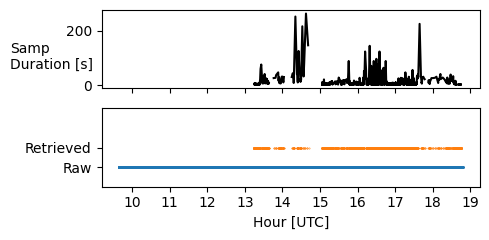

In [64]:
date = '2024_06_07'
#sems_per = get_sems_periods(datetime.strptime(date, '%Y_%m_%d'))
ft = get_flight_periods(datetime.strptime(date, '%Y_%m_%d'))
output = process('./data/DASH-flight-'+date+'/', 'RESAMP_240607', )